In [2]:
import os
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
TRAIN_PATH = './data/train/'
CSV_PATH = './data/train.csv'

IMG_SIZE = 380
IMG_SHAPE = (380, 380, 3)
EPOCHS = 15

In [4]:
traindf = pd.read_csv(CSV_PATH, sep='\t')

traindf['class_id'] = traindf['class_id'].astype(str)

#названия классов
CLASSES = ['None', 'Ded Moroz', 'Santa']

Классы несбалансированы. Для удобства уравняем количество сэмплов в каждом классе за счет дублирования некоторых элементов из отстающих классов: <br>
1) у нас будет аугментация данных, так что даже дублирующие картинки будут разными <br>
2) при сбалансированном распределении классов нам интуитивно проще оценивать точность. Мы не попадем в ситуцию, когда просто делая предсказания в виде самого популярного класса, мы правильно классифицируем большинство картинов

In [5]:
traindf['class_id'].value_counts()

0    800
1    240
2    240
Name: class_id, dtype: int64

In [6]:
count_max = traindf['class_id'].value_counts().max()

In [7]:
traindf = traindf.groupby('class_id', as_index=False).apply(lambda x:  x.sample(count_max, replace=True, random_state=24)).reset_index(drop=True)

In [8]:
traindf['class_id'].value_counts()

0    800
1    800
2    800
Name: class_id, dtype: int64

Перемешаем наш датасет, поскольку по умолчанию он отсортирован по классам.

In [115]:
traindf = traindf.sample(frac=1, random_state=1)

Обращаем внимание, что для валидационного датасета мы не будем использовать аугментацию данных, поскольку на инференсе это не имеет смысла. Так же не будем перемешивать валидационный датасет для удобства подсчета метрик в ручном режиме в дальнейшем.

In [116]:
datagen_train = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1,
        zoom_range=[0.75, 1],
        horizontal_flip=True,
        validation_split=0.2)

datagen_valid = ImageDataGenerator(validation_split=0.2)

train_data=datagen_train.flow_from_dataframe(
    dataframe=traindf,
    directory=TRAIN_PATH,
    x_col="image_name",
    y_col="class_id",
    subset="training",
    batch_size=16,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE,IMG_SIZE))

valid_data=datagen_valid.flow_from_dataframe(
    dataframe=traindf,
    directory=TRAIN_PATH,
    x_col="image_name",
    y_col="class_id",
    subset="validation",
    batch_size=16,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(IMG_SIZE,IMG_SIZE))

Found 1920 validated image filenames belonging to 3 classes.
Found 480 validated image filenames belonging to 3 classes.


Видим, что классы на валиде распределены достаточно ровно.

In [117]:
collections.Counter(valid_data.labels)

Counter({1: 179, 0: 157, 2: 144})

Визуализируем часть наших датасетов, убедимся что классы соответствуют изображениям.

In [11]:
def show_batch(image_batch, label_batch):
    fig = plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n]/255)
        plt.title(CLASSES[np.argmax(label_batch[n])], fontsize=14)
        plt.axis('off')
    plt.show()

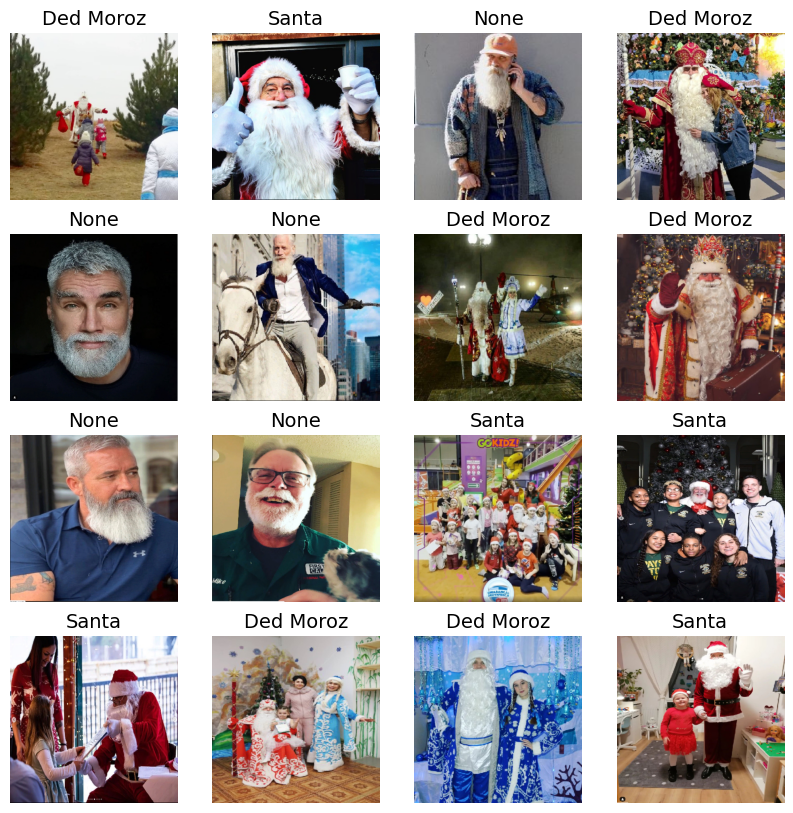

In [12]:
image_batch, label_batch = next(valid_data)
show_batch(image_batch, label_batch)

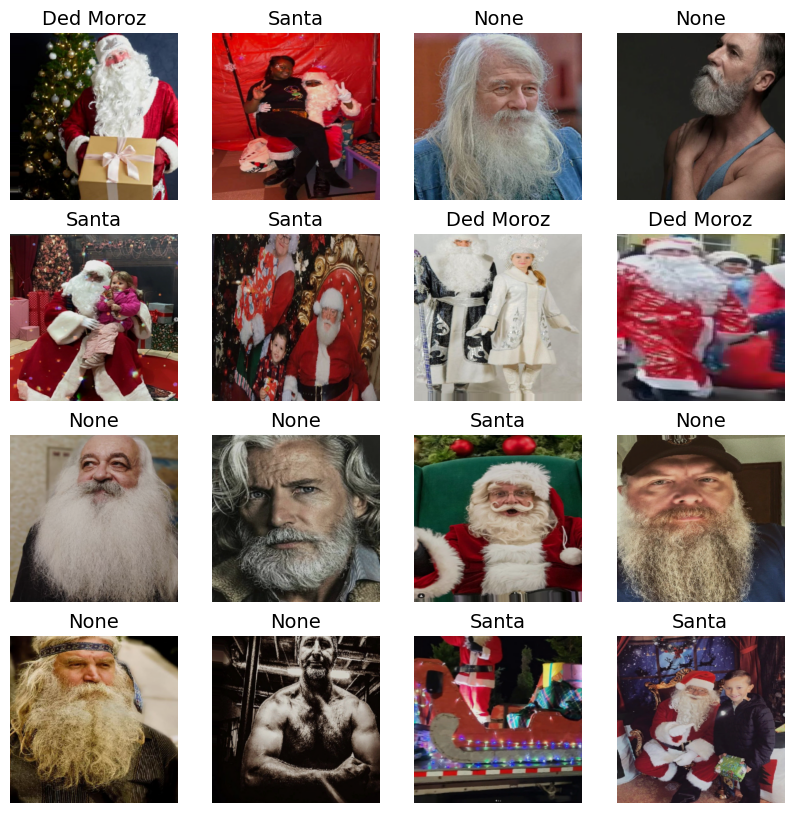

In [13]:
image_batch, label_batch = next(train_data)
show_batch(image_batch, label_batch)

### Обучение модели

В качестве базовой модели будем использовать EfficientNetB4 (не самая большая сеточка, в том числе и из-за некоторых ограничениях домашнего железа), предобученный на ImageNet. В моем случае я загружаю заранее скачанные веса. <br>
Модель загружена без слоя, отвечающего предсказание. Параметр trainable = False "замораживает веса" на слоях модели, которые отвечают за выделение признаков.

In [14]:
base_model = tf.keras.applications.EfficientNetB4(include_top=False,
                                                 weights='efficientnetb4_notop.h5',
                                                 input_shape=IMG_SHAPE)

base_model.trainable = False

Добавляем слой пулинга, чтобы преобразовать последний сверточный слой в вектор, и полносвязный слой для классификации 

In [15]:
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

Сохраняем веса в процессе обучения через callback

In [16]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    metrics=["acc"],
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./data/weight/checkpoints/',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_freq=3)

In [19]:
history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data=valid_data,
                    callbacks=[model_checkpoint_callback])

model.save('./data/weight/model_eff.h5')

Epoch 1/15
120/120 [==============================] - 774s 6s/step - loss: 0.6841 - acc: 0.7182 - val_loss: 0.4053 - val_acc: 0.8625
Epoch 2/15
120/120 [==============================] - 678s 6s/step - loss: 0.3472 - acc: 0.8536 - val_loss: 0.2346 - val_acc: 0.9250
Epoch 3/15
120/120 [==============================] - 634s 5s/step - loss: 0.2630 - acc: 0.8964 - val_loss: 0.1623 - val_acc: 0.9458
Epoch 4/15
120/120 [==============================] - 633s 5s/step - loss: 0.2239 - acc: 0.9099 - val_loss: 0.1297 - val_acc: 0.9542
Epoch 5/15
120/120 [==============================] - 632s 5s/step - loss: 0.2016 - acc: 0.9151 - val_loss: 0.1119 - val_acc: 0.9708
Epoch 6/15
120/120 [==============================] - 631s 5s/step - loss: 0.1768 - acc: 0.9297 - val_loss: 0.1005 - val_acc: 0.9667
Epoch 7/15
120/120 [==============================] - 628s 5s/step - loss: 0.1525 - acc: 0.9406 - val_loss: 0.0892 - val_acc: 0.9708
Epoch 8/15
120/120 [==============================] - 633s 5s/step - 

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Видим, что точность на обучающей и валидационной выборках растет, возможно стоило увеличить количество эпох и посмотреть, будет ли происходить рост точности или начнется переобучение

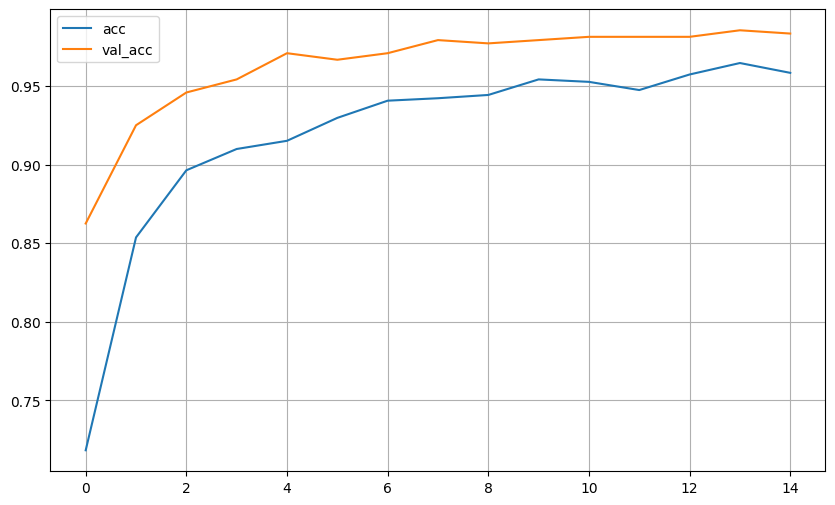

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'],  label='val_acc')
plt.legend()
plt.grid()
plt.show()


Так же была произведена попытка "разморозить" модель и попробовать дообучить её целиком с более низким learning rate. В конечном счете это не дало прибавку в качестве, поэтому fine-tuning в ноутбук не попал.

### Проверка модели

In [118]:
prediction = model.predict(valid_data)
prediction = np.argmax(prediction, axis=1)

In [121]:
from sklearn.metrics import accuracy_score

In [122]:
y_true = np.array(valid_data.labels)

Посчитаем метрику функцией из sklearn, сверим с тем что показывает модель. Делаем просто чтобы убедиться, что лейблы не съехали при работе с преобразованием датасета из датафрейма в тензоры.

In [123]:
accuracy_score(y_true, prediction)

0.9729166666666667

In [107]:
model.evaluate(valid_data)

30/30 [==============================] - 140s 5s/step - loss: 0.0860 - acc: 0.9729


[0.08595244586467743, 0.9729166626930237]

In [124]:
from sklearn.metrics import classification_report

Посмотрим основные метрики как по классам, так и в целом по выборке: <br>
1) по классу 0 (просто человек) высокий результат, модель практически безошибочно его определяет. Это вполне интуитивно, ведь этот класс сильно отличается от санта клаусов и дедов морозов. <br>
2) класс 1 (санта) имеет хороший precision, но низкий recall. Значит, у класса мало ошибок FP, но присутствует FN <br>
3) класс 2 (дед мороз) имеет приемлимый recall, но precision плох. <br>
Объединяя пункты 2 и 3 можно сделать вывод, что модель часто воспринимает санту за деда мороза. А обратная ошибка происходит, гораздо реже


In [125]:
print(classification_report(y_true, prediction, target_names=['0', '1', '2']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       157
           1       0.98      0.96      0.97       179
           2       0.94      0.97      0.96       144

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480



In [127]:
import pycm

In [128]:
cm = pycm.ConfusionMatrix(y_true, prediction)

Для удобства построим матрицу ошибок для многоклассовой классификации. По вертикали мы выдим реальные классы, а по горизонтали - предсказанные. Например, если мы возьмем класс 1, то увидим, что он был предсказан верно 172 раза, и 7 раз был ошибочно признан как класс 2.

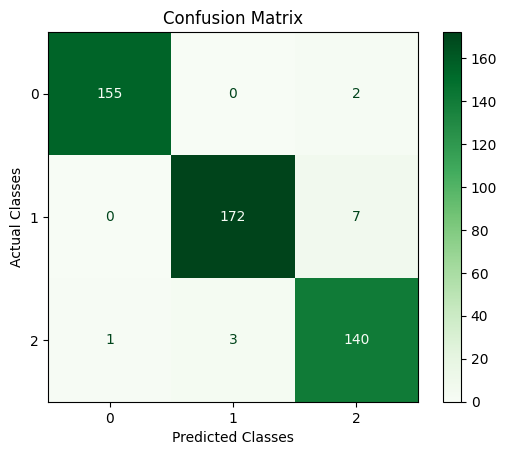

In [139]:
cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib")
plt.show()

### Inference

По условиям соревнования предсказание происходит автоматически на сервере организатора, посредством создания докер-контейнера и запуска обученной модели. Поэтому проверяем корректность работы кода и загружаем в репозиторий.

In [22]:
from tensorflow.keras.preprocessing import image

In [23]:
TEST_PATH = './data/test/'
MODEL_PATH = './data/weight/model_eff.h5'

In [24]:
test_data = []
images_list = []
for img in os.listdir(TEST_PATH):
    images_list.append(img)
    img = os.path.join(TEST_PATH, img)
    img = image.load_img(img, target_size=(IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    test_data.append(img)

test_data = np.vstack(test_data)

In [25]:
model = tf.keras.models.load_model(MODEL_PATH)
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(lr=0.0003),
    metrics=["acc"],
)

prediction = np.argmax(model.predict(test_data), axis=-1)

submit = pd.DataFrame({
                 'image_name': images_list,
                 'class_id': prediction        
                })

submit.to_csv('./data/out/submission.csv',  index=False, sep='\t')